# Data preparation Traffic&More




## Inleiding

Dit notebook beschrijft de data preparatie pipeline voor het voorspellen van kantelpunten 
(omslagpunten) in verkeersstromen bij Knooppunt Gouwe. De verwerkte data wordt gebruikt 
voor machine learning modellen die voorspellen wanneer een file dreigt te ontstaan.

### Doel van de data preparatie
De ruwe NDW-verkeersdata bevat ruis, ontbrekende waarden en inconsistenties. 
Deze pipeline transformeert de data naar een schone, verrijkte dataset geschikt voor 
het trainen van voorspellingsmodellen.

### Overzicht van de stappen

1. **Data Cleaning**  
   `remove_missing`, `remove_negs`, `drop_low`, `drop_columns`, `lanes`

2. **Datetime Features**  
   `datetime`, `time_to_int`, `dayofweek`

3. **Data Smoothing**  
   `smooth_data`

4. **Geo-verrijking**  
   `merge_with_geo`

5. **File Detectie & Labeling**  
   `add_helling_per_punt`, `detect_files`, `mark_omslagpunten`

6. **Sampling**  
   `undersample`

7. **Weerdata Preparatie**  
   `fix_names`, `fix_datetime`

## Import en data inladen

### Benodigde libraries

In [3]:

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

## Data Inladen

### Meetpunt selectie
Voor deze analyse is gekozen voor meetpunt **RWS01_MONIBAS_0121hrr0288ra**, gelegen bij Knooppunt Gouwe. 

In [4]:
df = pd.read_csv('../data/export_location_modeling/export_location_modeling.csv')

In [5]:
df.columns

Index(['id_meetlocatie', 'start_meetperiode', 'eind_meetperiode', 'ndw_index',
       'gem_intensiteit', 'gem_snelheid', 'totaal_aantal_rijstroken',
       'rijstrook_rijbaan', 'locatiecode_vild', 'specifieke_baan',
       'technical_exclusion', 'traffic_flow_deviation_exclusions'],
      dtype='object')

### Kolom beschrijvingen

| Kolomnaam | Beschrijving |
|------------|--------------|
| `id_meetlocatie` | Identiteit van de meetlocatie |
| `start_meetperiode` | Start van de periode waarover de gegevens in deze rij staan |
| `eind_meetperiode` | Einde van de periode waarover de gegevens in deze rij staan |
| `ndw_index` | Combinatie van voertuigcategorie en rijstrook |
| `gem_intensiteit` | Gemiddelde intensiteit (voertuigen/uur) |
| `gem_snelheid` | Gemiddelde snelheid (km/u) |
| `rijstrook_rijbaan` | Rijstrooknummer vanaf de middenberm |
| `totaal_aantal_rijstroken` | Totaal aantal rijstroken van de meetlocatie |
| `specifieke_baan` | Type rijbaan (mainCarriageway = hoofdrijbaan) |
| `locatiecode_vild` | Locatiecode van het VILD-punt |
| `technical_exclusion` | Markering voor technische storingen |
| `traffic_flow_deviation_exclusions` | Markering voor afwijkende verkeerspatronen |



## Data Cleaning

In deze stap verwijderen we ongeldige en onbruikbare data. Dit is essentieel omdat de ruwe NDW-data 
ruis bevat die de kwaliteit van ons model negatief beïnvloedt.

### remove_missing

De kolom `technical_exclusion` markeert meetperiodes met technische storingen. 
Daarnaast komen er rijen voor zonder snelheidsmetingen. Beide zijn onbruikbaar voor analyse.

**Wat doen we:**
- Verwijder de kolom `technical_exclusion`
- Verwijder rijen waar `gem_snelheid` ontbreekt (NaN)

In [6]:
def remove_missing(X):
    X = X.drop(columns=['technical_exclusion'])
    X = X[X.gem_snelheid.notna()]
    return X

In [7]:
# Toepassen
print(f"Rijen voor: {len(df):,}")
print(f"Kolommen voor: {len(df.columns)}")
print()
df_clean = remove_missing(df.copy())
print(f"Rijen na: {len(df_clean):,}")
print(f"Kolommen na: {len(df_clean.columns)}")

Rijen voor: 1,263,744
Kolommen voor: 12

Rijen na: 1,263,744
Kolommen na: 11


### remove_negs

In de NDW-data wordt de waarde `-1` gebruikt als placeholder wanneer een meting niet beschikbaar is. 
Dit zijn geen echte metingen en moeten verwijderd worden.

**Wat doen we:**
- Verwijder rijen waar `gem_snelheid` gelijk is aan -1
- Verwijder rijen waar `gem_intensiteit` gelijk is aan -1

In [8]:
def remove_negs(X):
    X = X[X.gem_snelheid != -1]
    X = X[X.gem_intensiteit != -1]
    return X

In [9]:
print(f"Rijen voor: {len(df_clean):,}")
df_clean = remove_negs(df_clean.copy())
print(f"Rijen na: {len(df_clean):,}")
print(f"Verwijderd: {len(df) - len(df_clean):,} rijen")

Rijen voor: 1,263,744
Rijen na: 1,171,150
Verwijderd: 92,594 rijen


### drop_low

Meetperiodes met een zeer lage intensiteit zijn niet representatief voor normale verkeerssituaties. 
Dit zijn vaak nachtelijke uren of momenten met weinig verkeer, waar filevorming niet relevant is.


**Wat doen we:**
- Verwijder rijen waar `gem_intensiteit` lager is dan 50 voertuigen per uur

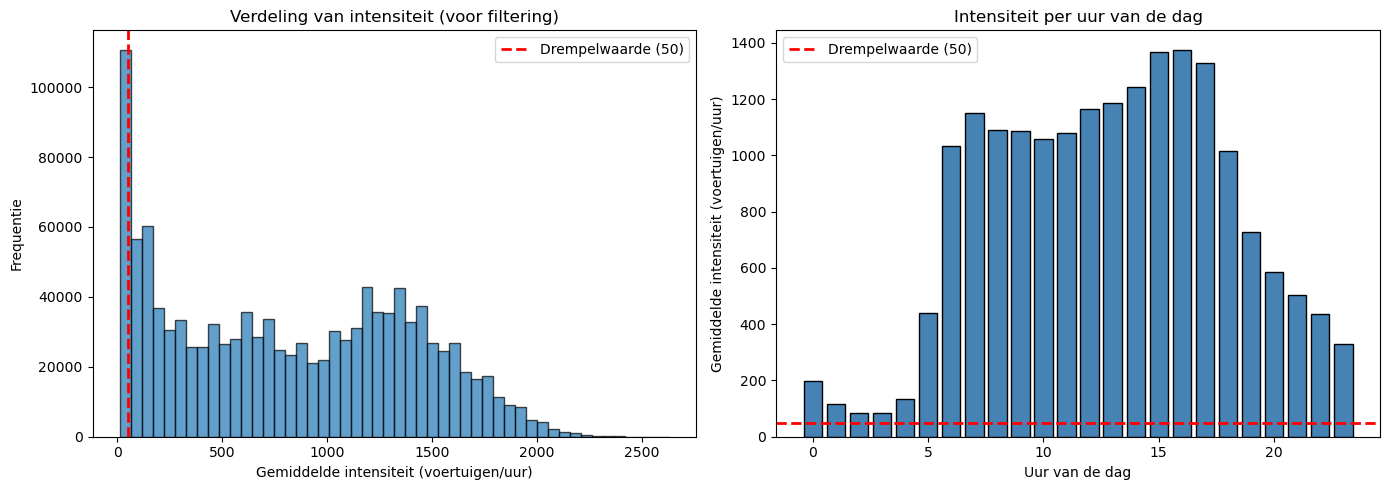

Aantal rijen met intensiteit <= 50: 94,117


In [10]:
# Plot VOOR drop_low
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Verdeling van intensiteit (voor filtering)
axes[0].hist(df_clean['gem_intensiteit'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=50, color='red', linestyle='--', linewidth=2, label='Drempelwaarde (50)')
axes[0].set_xlabel('Gemiddelde intensiteit (voertuigen/uur)')
axes[0].set_ylabel('Frequentie')
axes[0].set_title('Verdeling van intensiteit (voor filtering)')
axes[0].legend()

# Plot 2: Gemiddelde intensiteit per uur van de dag
df_clean['uur'] = pd.to_datetime(df_clean['start_meetperiode']).dt.hour
gem_per_uur = df_clean.groupby('uur')['gem_intensiteit'].mean()
axes[1].bar(gem_per_uur.index, gem_per_uur.values, color='steelblue', edgecolor='black')
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Drempelwaarde (50)')
axes[1].set_xlabel('Uur van de dag')
axes[1].set_ylabel('Gemiddelde intensiteit (voertuigen/uur)')
axes[1].set_title('Intensiteit per uur van de dag')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Aantal rijen met intensiteit <= 50: {len(df_clean[df_clean['gem_intensiteit'] <= 50]):,}")

In [11]:
def drop_low(X):
    X = X[X.gem_intensiteit > 50]
    return X

In [12]:
# Toepassen
print(f"Rijen voor: {len(df_clean):,}")
df_clean = drop_low(df_clean.copy())
print(f"Rijen na: {len(df_clean):,}")

Rijen voor: 1,171,150
Rijen na: 1,077,033


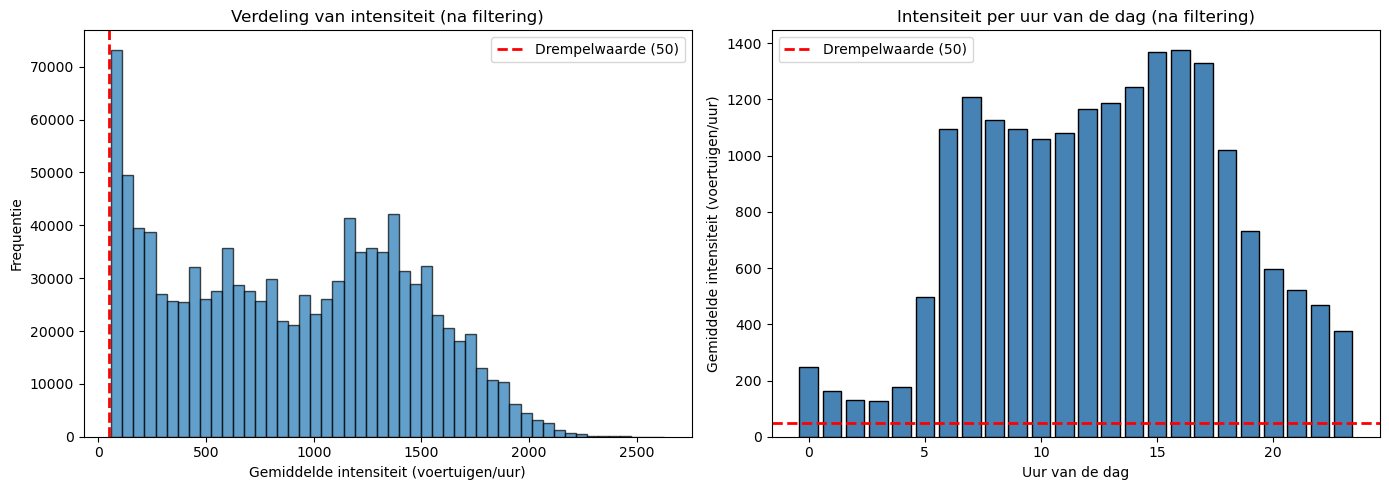

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df_clean['gem_intensiteit'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=50, color='red', linestyle='--', linewidth=2, label='Drempelwaarde (50)')
axes[0].set_xlabel('Gemiddelde intensiteit (voertuigen/uur)')
axes[0].set_ylabel('Frequentie')
axes[0].set_title('Verdeling van intensiteit (na filtering)')
axes[0].legend()

df_clean['uur'] = pd.to_datetime(df_clean['start_meetperiode']).dt.hour
gem_per_uur = df_clean.groupby('uur')['gem_intensiteit'].mean()
axes[1].bar(gem_per_uur.index, gem_per_uur.values, color='steelblue', edgecolor='black')
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Drempelwaarde (50)')
axes[1].set_xlabel('Uur van de dag')
axes[1].set_ylabel('Gemiddelde intensiteit (voertuigen/uur)')
axes[1].set_title('Intensiteit per uur van de dag (na filtering)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [14]:
print(f"Minimale intensiteit: {df_clean['gem_intensiteit'].min()}")
print(f"Aantal rijen met intensiteit <= 50: {len(df_clean[df_clean['gem_intensiteit'] <= 50])}")

Minimale intensiteit: 60.0
Aantal rijen met intensiteit <= 50: 0


### drop_columns

De kolom `traffic_flow_deviation_exclusions` markeert afwijkende verkeerspatronen die niet geschikt zijn voor normale verkeersanalyse. Deze kolom is niet nodig voor onze analyse en wordt verwijderd.

**Wat doen we:**
- Verwijder de kolom `traffic_flow_deviation_exclusions`

In [15]:
def drop_columns(X):
    X.drop(columns=['traffic_flow_deviation_exclusions'])
    return X

In [16]:
print(f"Rijen voor: {len(df_clean):,}")
print(f"Kolommen voor: {len(df_clean.columns)}")
print()
df_clean = drop_columns(df_clean.copy())
print(f"Rijen na: {len(df_clean):,}")
print(f"Kolommen na: {len(df_clean.columns)}")

Rijen voor: 1,077,033
Kolommen voor: 12

Rijen na: 1,077,033
Kolommen na: 12


## Datetime Features

Tijd speelt een cruciale rol in verkeerspatronen. Spitsuren, weekdagen versus weekenden, en seizoenen hebben elk een direct effect op verkeersintensiteit en filevorming.

### datetime

Converteer de `start_meetperiode` kolom naar een datetime object en voeg een `datum` kolom toe voor eenvoudige datum-gebaseerde analyses.

**Wat doen we:**
- Converteer `start_meetperiode` naar datetime formaat
- Maak een nieuwe kolom `datum` met alleen de datum (zonder tijd)

In [17]:
def datetime(X):
    X['start_meetperiode'] = pd.to_datetime(X['start_meetperiode'])

    X['datum'] = X['start_meetperiode'].dt.date
     
    # look into time zones
    return X

In [18]:
print(f"Type voor: {type(df_clean['start_meetperiode'].iloc[0])}")
df_clean = datetime(df_clean.copy())
print(f"Type na: {type(df_clean['start_meetperiode'].iloc[0])}")
print(f"\nVoorbeeld datum: {df_clean['datum'].iloc[0]}")
print(f"Aantal kolommen: {len(df_clean.columns)}")

Type voor: <class 'str'>
Type na: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

Voorbeeld datum: 2022-12-15
Aantal kolommen: 13


### time_to_int

Machine learning modellen werken beter met numerieke waarden dan met datetime objecten. Door tijd om te zetten naar seconden sinds middernacht, creëren we een continue numerieke feature die het tijdstip van de dag representeert.

**Wat doen we:**
- Converteer het tijdstip naar seconden sinds middernacht (0-86399)
- Dit maakt het mogelijk om patronen zoals ochtendspits (6:00-9:00) numeriek te leren

In [19]:
def time_to_int(X):
    X['tijd'] = X['start_meetperiode'].dt.hour*3600 + \
                X['start_meetperiode'].dt.minute*60 + \
                X['start_meetperiode'].dt.second
    return X

In [20]:
df_clean = time_to_int(df_clean.copy())
print(f"Nieuwe kolom 'tijd' toegevoegd")
print(f"\nVoorbeeld tijden:")
print(df_clean[['start_meetperiode', 'tijd']].head(3))
print(f"\nBereik: {df_clean['tijd'].min()} - {df_clean['tijd'].max()} seconden")

Nieuwe kolom 'tijd' toegevoegd

Voorbeeld tijden:
    start_meetperiode  tijd
2 2022-12-15 00:00:00     0
3 2022-12-15 00:00:00     0
6 2022-12-15 00:05:00   300

Bereik: 0 - 86100 seconden


### dayofweek

Verkeersdrukte verschilt sterk tussen weekdagen en weekenden. Maandag tot vrijdag hebben spitsuren, terwijl weekenden vaak een ander verkeerspatroon hebben.

**Wat doen we:**
- Voeg een `day_of_week` kolom toe (0=Maandag, 6=Zondag)
- Dit helpt het model om weekendverkeer te onderscheiden van werkdagverkeer

In [21]:
def dayofweek(X):
    X["day_of_week"] = pd.to_datetime(X["datum"]).dt.dayofweek
    return X

In [22]:
df_clean = dayofweek(df_clean.copy())
print(f"Nieuwe kolom 'day_of_week' toegevoegd")
print(f"\nVerdeling per dag:")
dag_namen = ['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag']
for dag_nr in range(7):
    count = len(df_clean[df_clean['day_of_week'] == dag_nr])
    print(f"  {dag_namen[dag_nr]} ({dag_nr}): {count:,} metingen")

Nieuwe kolom 'day_of_week' toegevoegd

Verdeling per dag:
  Maandag (0): 154,285 metingen
  Dinsdag (1): 153,100 metingen
  Woensdag (2): 153,489 metingen
  Donderdag (3): 155,187 metingen
  Vrijdag (4): 158,769 metingen
  Zaterdag (5): 155,537 metingen
  Zondag (6): 146,666 metingen


## Data Smoothing

Ruwe sensordata bevat vaak ruis door meetfouten, tijdelijke verstoringen, of wisselende verkeerssituaties. Door de data te smoothen kunnen we echte trends beter onderscheiden van willekeurige variaties.

### smooth_data

We gebruiken het **Savitzky-Golay filter** om de snelheid en intensiteit te smoothen. Dit filter past een polynoom aan door een sliding window van datapunten, waardoor het beter dan een simpel voortschrijdend gemiddelde is omdat het trends behoudt.

**Keuze voor Savitzky-Golay:**
- Behoudt pieken en dalen beter dan een moving average
- Vermindert hoogfrequente ruis
- Window van 7 meetperiodes (= 35 minuten bij 5-min intervallen)
- Polynoom orde 2 (kwadratisch)

In [23]:
def smooth_data(X):
    y = X['gem_snelheid'].values
    y_smooth = savgol_filter(y, window_length=min(7, len(y) - (1 if len(y) % 2 == 0 else 0)), polyorder=2)
    X["gem_snelheid_smooth"] = y_smooth

    z = X['gem_intensiteit'].values
    z_smooth = savgol_filter(z, window_length=min(7, len(z) - (1 if len(z) % 2 == 0 else 0)), polyorder=2)
    X["gem_intensiteit_smooth"] = z_smooth   
    
    return X

In [24]:
df_clean = smooth_data(df_clean.copy())
print(f"Smoothing toegepast")
print(f"\nVergelijking origineel vs smooth:")
print(df_clean[['gem_snelheid', 'gem_snelheid_smooth', 'gem_intensiteit', 'gem_intensiteit_smooth']].head(10))

Smoothing toegepast

Vergelijking origineel vs smooth:
    gem_snelheid  gem_snelheid_smooth  gem_intensiteit  gem_intensiteit_smooth
2         117.01           111.965952            300.0              314.857143
3         102.11           109.967857            276.0              271.714286
6         111.97           108.141429            228.0              240.857143
7          97.40           106.486667            348.0              222.285714
9         112.21           105.537143             96.0              228.571429
10        110.25           105.827143            204.0              184.000000
11         96.86           111.188571            276.0              165.714286
13        118.68           107.118095             72.0              243.428571
14        114.05           111.157619            300.0              217.714286
15        100.31           116.765714            300.0              199.428571


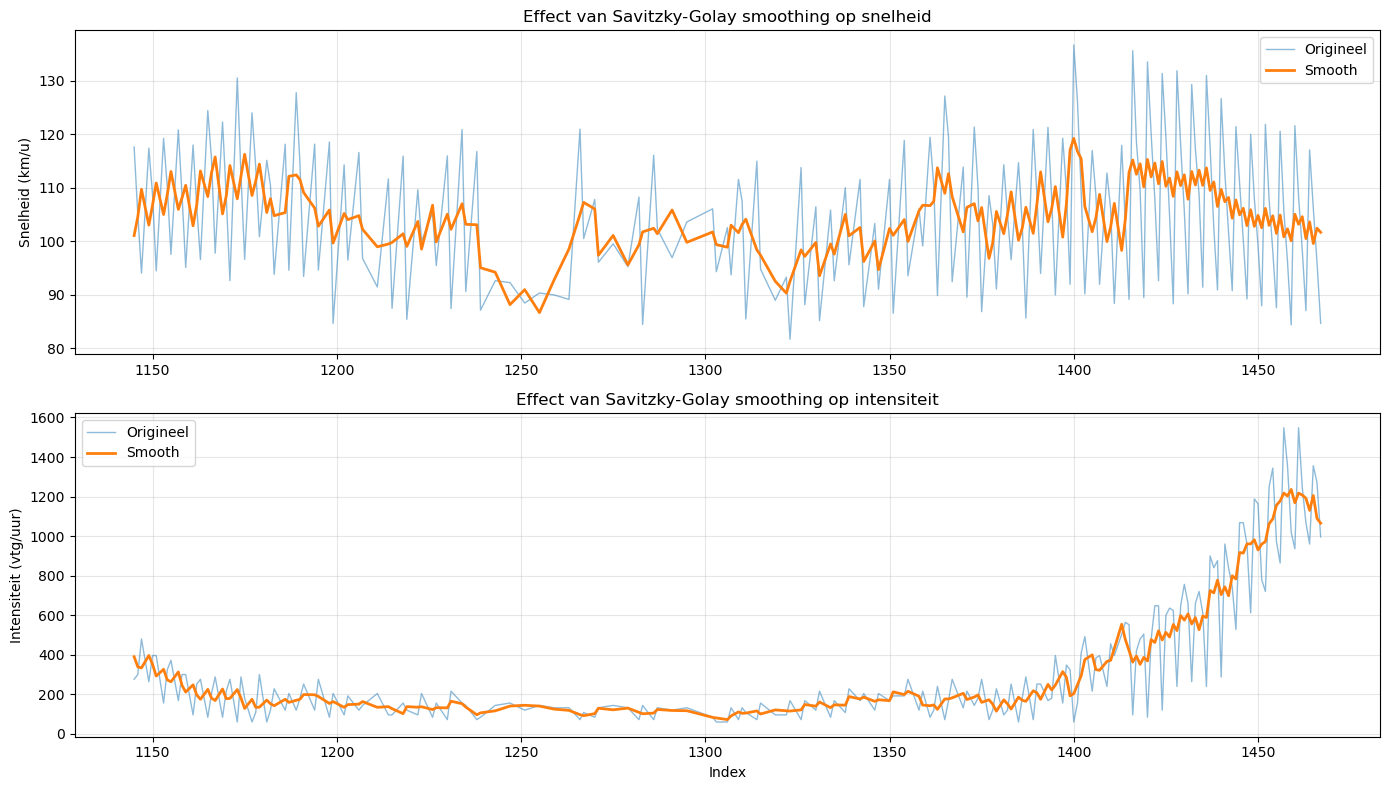

In [25]:
# Visualiseer het effect van smoothing
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Selecteer een subset van 200 opeenvolgende metingen voor visualisatie
subset = df_clean.iloc[1000:1200]

# Plot 1: Snelheid
axes[0].plot(subset.index, subset['gem_snelheid'], label='Origineel', alpha=0.5, linewidth=1)
axes[0].plot(subset.index, subset['gem_snelheid_smooth'], label='Smooth', linewidth=2)
axes[0].set_ylabel('Snelheid (km/u)')
axes[0].set_title('Effect van Savitzky-Golay smoothing op snelheid')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Intensiteit
axes[1].plot(subset.index, subset['gem_intensiteit'], label='Origineel', alpha=0.5, linewidth=1)
axes[1].plot(subset.index, subset['gem_intensiteit_smooth'], label='Smooth', linewidth=2)
axes[1].set_ylabel('Intensiteit (vtg/uur)')
axes[1].set_xlabel('Index')
axes[1].set_title('Effect van Savitzky-Golay smoothing op intensiteit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Geo-verrijking

Om de verkeersdata in context te plaatsen, voegen we geografische informatie toe uit de NDW shapefiles. Dit geeft ons wegtype, exacte coördinaten, en andere locatie-specifieke kenmerken.

### merge_with_geo

**Wat doen we:**
- Lees de NDW shapefile met telpunt-informatie
- Koppel deze aan onze data op basis van `id_meetlocatie`
- Converteer naar een GeoDataFrame met geometry kolom
- Voeg wegtype informatie toe (hoofdrijbaan, op-/afrit, etc.)

In [32]:
# Lees de shapefile
telpunten_gdf = gpd.read_file("../data/meetpunt_locaties/NDW_AVG_Meetlocaties_Shapefile/Telpunten_WGS84.shp")

print(f"Shapefile geladen: {len(telpunten_gdf)} telpunten")
print(f"Kolommen: {telpunten_gdf.columns.tolist()}")

Shapefile geladen: 19799 telpunten
Kolommen: ['id', 'naam', 'dgl_loc', 'meetricht', 'wegtype', 'meetgeg', 'ref_mvak', 'geometry']


In [33]:
def merge_with_geo(X, telpunten_gdf):
    # Bereid geo info voor
    geo_info = telpunten_gdf[['dgl_loc', 'wegtype', 'geometry']].copy()
    geo_info.rename(columns={'dgl_loc': 'id_meetlocatie'}, inplace=True)

    # Merge
    data_verrijkt = pd.merge(X, geo_info, on='id_meetlocatie', how='left')

    # Converteer naar GeoDataFrame
    gdf_verrijkt = gpd.GeoDataFrame(
        data_verrijkt.dropna(subset=['geometry']),
        geometry='geometry',
        crs="EPSG:4326"
    )
    return gdf_verrijkt

In [34]:
df_clean = merge_with_geo(df_clean.copy(), telpunten_gdf)
print(f"Type: {type(df_clean)}")
print(f"Shape: {df_clean.shape}")
print(f"CRS: {df_clean.crs}")
print(f"\nWegtype verdeling:")
print(df_clean['wegtype'].value_counts())

Type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape: (1077033, 19)
CRS: EPSG:4326

Wegtype verdeling:
wegtype
H    1077033
Name: count, dtype: int64


## File Detectie & Labeling

Dit is de kern van onze data preparatie: het identificeren van files en het markeren van omslagpunten. Deze labels vormen de target variabele voor ons machine learning model.

### add_helling_per_punt

Voordat we files kunnen detecteren, berekenen we eerst de **helling** (rate of change) van de snelheid over tijd. Een sterke negatieve helling duidt op een plotselinge snelheidsafname en dus een potentieel kantelpunt.

**Methode:**
- Gebruik een sliding window van 5 metingen (25 minuten)
- Fit een lineaire regressie door elk window
- De slope van deze lijn is de helling
- Negatieve helling = snelheid daalt
- Positieve helling = snelheid stijgt

In [35]:
def add_helling_per_punt(df, window_size=5, slope_col="helling_per_punt"):
    df = df.copy()

    if "id_meetlocatie" not in df.columns:
        raise ValueError("Kolom 'id_meetlocatie' ontbreekt in de DataFrame.")

    # sorteren per meetlocatie en tijd
    df = df.sort_values(["id_meetlocatie", "start_meetperiode"]).reset_index(drop=True)

    # lege kolom voor hellingen
    df[slope_col] = np.nan

    # per meetlocatie apart helling berekenen
    for loc_id, group in df.groupby("id_meetlocatie", sort=False):
        idx = group.index.to_list()
        speeds = group["gem_snelheid"].values

        slopes = np.full(len(group), np.nan)

        for i in range(len(group) - window_size + 1):
            window = speeds[i:i + window_size]

            # alleen fitten wanneer alle waarden geldig zijn
            if np.all(np.isfinite(window)):
                x = np.arange(window_size)
                slope, _ = np.polyfit(x, window, 1)
                slopes[i] = slope

        # terugschrijven in originele df
        df.loc[idx, slope_col] = slopes

    return df

In [36]:
df_clean = add_helling_per_punt(df_clean.copy())
print(f"Helling berekend")
print(f"\nStatistieken helling:")
print(f"  Gemiddeld: {df_clean['helling_per_punt'].mean():.4f}")
print(f"  Mediaan: {df_clean['helling_per_punt'].median():.4f}")
print(f"  Min (sterkste daling): {df_clean['helling_per_punt'].min():.4f}")
print(f"  Max (sterkste stijging): {df_clean['helling_per_punt'].max():.4f}")
print(f"  NaN waarden: {df_clean['helling_per_punt'].isna().sum():,}")

Helling berekend

Statistieken helling:
  Gemiddeld: 0.0000
  Mediaan: -0.1240
  Min (sterkste daling): -27.0550
  Max (sterkste stijging): 28.4300
  NaN waarden: 4


### detect_files

Nu detecteren we daadwerkelijke files op basis van snelheidsdrempels. We gebruiken een two-threshold methode:
- **Start threshold**: File begint wanneer snelheid < 50 km/u
- **End threshold**: File eindigt pas wanneer snelheid ≥ 75 km/u voor 2 opeenvolgende metingen

**Waarom twee drempels?**
Dit voorkomt dat tijdelijke snelheidspieken de file vroegtijdig beëindigen. Een file moet echt hersteld zijn voordat we hem als "beëindigd" markeren.

**Let op:** Van dit punt zijn er een aantal functies die niet van ons zijn (overgenomen uit externe bronnen).

In [37]:
def detect_files(df, start_speed=50, end_speed=75, end_steps_required=2):
    """
    Detecteer files per meetlocatie en ken een file-ID toe per segment.

    Logica:
    - File start wanneer snelheid < start_speed
    - File stopt pas nadat end_steps_required opeenvolgende punten >= end_speed zijn
    """

    df = df.copy()

    # We moeten per locatie aparte file-id's bepalen
    if "id_meetlocatie" not in df.columns:
        raise ValueError("Kolom 'id_meetlocatie' ontbreekt.")

    df = df.sort_values(["id_meetlocatie", "start_meetperiode"]).reset_index(drop=True)

    df["file_id"] = np.nan
    current_file = 0  # numerieke teller voor file-segmenten

    # Per meetlocatie apart analyseren
    for loc_id, group in df.groupby("id_meetlocatie", sort=False):
        idx = group.index
        speeds = group["gem_snelheid"].values

        inside_file = False
        end_streak = 0  # hoeveel punten op rij boven herstel-waarde

        # Itereer chronologisch door rij-indexen van deze locatie
        for k, row_idx in enumerate(idx):
            speed = speeds[k]

            # Wanneer we niet in een file zitten → wacht op daling
            if not inside_file:
                if speed < start_speed:
                    inside_file = True
                    current_file += 1  # nieuwe file start
                    df.at[row_idx, "file_id"] = current_file
                    end_streak = 0
            else:
                # We zitten binnen een file → zelfde ID blijft lopen
                df.at[row_idx, "file_id"] = current_file

                # Check herstelconditie
                if speed >= end_speed:
                    end_streak += 1
                    # wanneer snel genoeg herstel is gedetecteerd → file eindigt
                    if end_streak >= end_steps_required:
                        inside_file = False
                        end_streak = 0
                else:
                    # herstel is onderbroken
                    end_streak = 0

    print(f"Totaal gedetecteerde files: {int(df['file_id'].nunique(dropna=True))}")
    return df

In [38]:
df_clean = detect_files(df_clean.copy())
print(f"\nFile detectie resultaten:")
print(f"  Totaal metingen: {len(df_clean):,}")
print(f"  Metingen in file: {df_clean['file_id'].notna().sum():,}")
print(f"  Percentage in file: {df_clean['file_id'].notna().sum()/len(df_clean)*100:.2f}%")
print(f"\nPer meetlocatie:")
for loc in df_clean['id_meetlocatie'].unique():
    files = df_clean[df_clean['id_meetlocatie'] == loc]['file_id'].nunique(dropna=True)
    print(f"  {loc}: {files} files")

Totaal gedetecteerde files: 857

File detectie resultaten:
  Totaal metingen: 1,077,033
  Metingen in file: 13,310
  Percentage in file: 1.24%

Per meetlocatie:
  RWS01_MONIBAS_0121hrr0288ra: 857 files


### mark_omslagpunten

Dit is de belangrijkste stap: het markeren van **omslagpunten** (tipping points), dit is het moment vlak voor een file ontstaat.

**Strategie:**
Voor elke gedetecteerde file kijken we 5 metingen (25 minuten) terug en zoeken naar het punt met de sterkste negatieve helling. Dit is het moment waarop de snelheid het snelst begon te dalen, ons kantelpunt.

**Belangrijke checks:**
- Overlapping voorkomen: Een omslagpunt kan niet binnen een eerdere file liggen
- Per meetlocatie afzonderlijk: Files op verschillende locaties beïnvloeden elkaar niet
- Alleen punten buiten file-periodes: Omslagpunt moet voor de file zijn

In [39]:
def mark_omslagpunten(df, window_back=5, slope_col="helling_per_punt"):
    """
    Per file (per meetlocatie) wordt één omslagpunt gemarkeerd.
    """

    df = df.copy()

    if "id_meetlocatie" not in df.columns:
        raise ValueError("Kolom 'id_meetlocatie' niet gevonden.")
    if "file_id" not in df.columns:
        raise ValueError("Kolom 'file_id' niet gevonden. Draai eerst detect_files(df).")
    if slope_col not in df.columns:
        raise ValueError(
            f"Kolom '{slope_col}' niet gevonden. "
            "Draai eerst add_helling_per_punt(df) of geef een andere slope_col mee."
        )

    # sorteren per meetlocatie én tijd, zodat indexblokken per locatie netjes zijn
    df = df.sort_values(["id_meetlocatie", "start_meetperiode"]).reset_index(drop=True)

    df["file_omslag_flag"] = 0

    n_files = int(df["file_id"].nunique(dropna=True))
    n_marked = 0

    # per meetlocatie apart omslagpunten zoeken
    for loc_id, group in df.groupby("id_meetlocatie", sort=False):
        loc_idx = group.index
        loc_min_idx = loc_idx.min()

        # voor deze locatie: laatste omslagindex (mag niet overlappen)
        last_omslag_idx = loc_min_idx - 1

        files_loc = group["file_id"].dropna().unique()

        for fid in files_loc:
            file_idx = group.index[group["file_id"] == fid].tolist()
            if not file_idx:
                continue

            start_idx = file_idx[0]

            # window vóór file-start, maar binnen deze meetlocatie blijven
            start_window = max(loc_min_idx, start_idx - window_back)
            end_window = start_idx - 1
            if end_window < start_window:
                continue

            window_idx = list(range(start_window, end_window + 1))

            # laatste index in window met file_id (eerdere file binnen dezelfde locatie)
            file_indices_in_window = [
                i for i in window_idx if not pd.isna(df.at[i, "file_id"])
            ]
            last_file_idx_in_window = max(file_indices_in_window) if file_indices_in_window else -1

            # grens: na laatste omslagpunt én na laatste file-index in window
            threshold = max(last_omslag_idx, last_file_idx_in_window)

            # kandidaten: zonder file_id en ná threshold
            candidate_idx = [
                i for i in window_idx
                if pd.isna(df.at[i, "file_id"]) and i > threshold
            ]

            omslag_idx = None

            if candidate_idx:
                slopes_window = df.loc[candidate_idx, slope_col].dropna()
                if not slopes_window.empty:
                    negatives = slopes_window[slopes_window < 0]
                    if not negatives.empty:
                        omslag_idx = negatives.idxmin()      # meest negatieve helling
                    else:
                        omslag_idx = slopes_window.idxmin()  # kleinste (beste) helling

            # fallback: geen kandidaten → punt direct vóór file-start
            if omslag_idx is None:
                if end_window > last_omslag_idx:
                    omslag_idx = end_window
                else:
                    continue  # zelfs dat niet mogelijk

            df.at[omslag_idx, "file_omslag_flag"] = 1
            n_marked += 1
            last_omslag_idx = omslag_idx

    print("-----------------------------------------------------")
    print(f"Detected files (unique file_id): {n_files}")
    print(f"Marked omslagpunten:             {n_marked}")
    print("-----------------------------------------------------")

    return df

In [40]:
df_clean = mark_omslagpunten(df_clean.copy())
print(f"\nClass balance:")
print(df_clean['file_omslag_flag'].value_counts())
print(f"\nPercentage omslagpunten: {df_clean['file_omslag_flag'].sum()/len(df_clean)*100:.4f}%")

-----------------------------------------------------
Detected files (unique file_id): 857
Marked omslagpunten:             857
-----------------------------------------------------

Class balance:
file_omslag_flag
0    1076176
1        857
Name: count, dtype: int64

Percentage omslagpunten: 0.0796%


## Sampling

We hebben nu een sterk **class imbalance probleem**: slechts een klein percentage van de data zijn daadwerkelijke omslagpunten. Dit kan machine learning modellen vertekenen.

### undersample

We gebruiken **undersampling** van de meerderheidsklasse (geen file) om de balans te herstellen. We behouden alle omslagpunten (minority class) en samplen de rest met een ratio van 3:1.

**Waarom 3:1?**
- 1:1 zou te weinig data opleveren
- 10:1 is nog te ongebalanceerd
- 3:1 is een goede balans tussen datavolume en class balance

In [41]:
def undersample(df, minority_class=1, ratio=3, random=17):
    df_minority = df[df["file_omslag_flag"] == minority_class].copy()
    df_majority = df[df["file_omslag_flag"] != minority_class].copy()
    n_minority = len(df_minority)
    n_majority_target = int(n_minority * ratio)
    df_majority_undersampled = df_majority.sample(n=n_majority_target,random_state=random)
    df_undersampled = pd.concat([df_minority, df_majority_undersampled], ignore_index=True)    
    return df_undersampled

In [42]:
print(f"Voor undersampling:")
print(f"  Totaal: {len(df_clean):,}")
print(f"  Omslagpunten: {(df_clean['file_omslag_flag']==1).sum():,}")
print(f"  Geen omslag: {(df_clean['file_omslag_flag']==0).sum():,}")
print()

df_balanced = undersample(df_clean.copy(), ratio=3)

print(f"Na undersampling:")
print(f"  Totaal: {len(df_balanced):,}")
print(f"  Omslagpunten: {(df_balanced['file_omslag_flag']==1).sum():,}")
print(f"  Geen omslag: {(df_balanced['file_omslag_flag']==0).sum():,}")
print(f"\nRatio: {(df_balanced['file_omslag_flag']==0).sum() / (df_balanced['file_omslag_flag']==1).sum():.2f}:1")

Voor undersampling:
  Totaal: 1,077,033
  Omslagpunten: 857
  Geen omslag: 1,076,176

Na undersampling:
  Totaal: 3,428
  Omslagpunten: 857
  Geen omslag: 2,571

Ratio: 3.00:1


## Samenvattting

We hebben nu een volledig verwerkte dataset die klaar is voor machine learning. Laten we de finale dataset inspecteren.

In [43]:
print(f"Shape: {df_balanced.shape}")
print(f"\nKolommen ({len(df_balanced.columns)}):")
for col in df_balanced.columns:
    dtype = df_balanced[col].dtype
    null_count = df_balanced[col].isna().sum()
    print(f"  {col:30s} {str(dtype):15s} ({null_count} nulls)")

print(f"\nTarget variabele distributie:")
print(df_balanced['file_omslag_flag'].value_counts())
print(f"\nPeriode: {df_balanced['start_meetperiode'].min()} tot {df_balanced['start_meetperiode'].max()}")

Shape: (3428, 22)

Kolommen (22):
  id_meetlocatie                 object          (0 nulls)
  start_meetperiode              datetime64[ns]  (0 nulls)
  eind_meetperiode               object          (0 nulls)
  ndw_index                      object          (0 nulls)
  gem_intensiteit                float64         (0 nulls)
  gem_snelheid                   float64         (0 nulls)
  totaal_aantal_rijstroken       int64           (0 nulls)
  rijstrook_rijbaan              object          (0 nulls)
  locatiecode_vild               int64           (0 nulls)
  specifieke_baan                object          (0 nulls)
  traffic_flow_deviation_exclusions float64         (3428 nulls)
  uur                            int32           (0 nulls)
  datum                          object          (0 nulls)
  tijd                           int32           (0 nulls)
  day_of_week                    int32           (0 nulls)
  gem_snelheid_smooth            float64         (0 nulls)
  gem_intensitei

In [44]:
df_balanced.head(10)

,id_meetlocatie,start_meetperiode,eind_meetperiode,ndw_index,gem_intensiteit,gem_snelheid,totaal_aantal_rijstroken,rijstrook_rijbaan,locatiecode_vild,specifieke_baan,...,datum,tijd,day_of_week,gem_snelheid_smooth,gem_intensiteit_smooth,wegtype,geometry,helling_per_punt,file_id,file_omslag_flag
0,RWS01_MONIBAS_0121hrr0288ra,2022-12-15 08:40:00,2022-12-15 08:45:00,F3A,1620.0,80.22,4,lane2,7272,mainCarriageway,...,2022-12-15,31200,3,81.948095,1369.714286,H,POINT (4.68712 52.03107),-11.256,NaN,1
1,RWS01_MONIBAS_0121hrr0288ra,2022-12-15 17:45:00,2022-12-15 17:50:00,F3A,1704.0,61.14,4,lane2,7272,mainCarriageway,...,2022-12-15,63900,3,63.078571,1530.285714,H,POINT (4.68712 52.03107),-8.562,NaN,1
2,RWS01_MONIBAS_0121hrr0288ra,2022-12-16 15:45:00,2022-12-16 15:50:00,F3A,1440.0,101.76,4,lane2,7272,mainCarriageway,...,2022-12-16,56700,4,103.179048,1246.857143,H,POINT (4.68712 52.03107),-15.928,NaN,1
3,RWS01_MONIBAS_0121hrr0288ra,2022-12-16 17:05:00,2022-12-16 17:10:00,F3A,1896.0,89.27,4,lane2,7272,mainCarriageway,...,2022-12-16,61500,4,91.245238,1641.142857,H,POINT (4.68712 52.03107),-13.135,NaN,1
4,RWS01_MONIBAS_0121hrr0288ra,2022-12-19 12:25:00,2022-12-19 12:30:00,F7A,1032.0,81.25,4,lane4,7272,mainCarriageway,...,2022-12-19,44700,0,88.980476,968.571429,H,POINT (4.68712 52.03107),-8.917,NaN,1
5,RWS01_MONIBAS_0121hrr0288ra,2023-01-19 07:30:00,2023-01-19 07:35:00,F3A,2076.0,78.02,4,lane2,7272,mainCarriageway,...,2023-01-19,27000,3,80.328095,1868.571429,H,POINT (4.68712 52.03107),-12.635,NaN,1
6,RWS01_MONIBAS_0121hrr0288ra,2023-01-23 07:35:00,2023-01-23 07:40:00,F3A,1884.0,84.66,4,lane2,7272,mainCarriageway,...,2023-01-23,27300,0,88.406190,1686.857143,H,POINT (4.68712 52.03107),-16.083,NaN,1
7,RWS01_MONIBAS_0121hrr0288ra,2023-01-24 08:00:00,2023-01-24 08:05:00,F3A,1476.0,76.12,4,lane2,7272,mainCarriageway,...,2023-01-24,28800,1,78.783810,1253.142857,H,POINT (4.68712 52.03107),-18.023,NaN,1
8,RWS01_MONIBAS_0121hrr0288ra,2023-01-26 08:50:00,2023-01-26 08:55:00,F3A,1488.0,103.04,4,lane2,7272,mainCarriageway,...,2023-01-26,31800,3,107.573810,1262.285714,H,POINT (4.68712 52.03107),-24.764,NaN,1
9,RWS01_MONIBAS_0121hrr0288ra,2023-02-02 07:55:00,2023-02-02 08:00:00,F3A,1896.0,93.72,4,lane2,7272,mainCarriageway,...,2023-02-02,28500,3,95.503810,1571.428571,H,POINT (4.68712 52.03107),-13.227,NaN,1


## Visualisatie van een omslagpunt

Laten we één omslagpunt visualiseren om te controleren of onze detectie correct werkt.

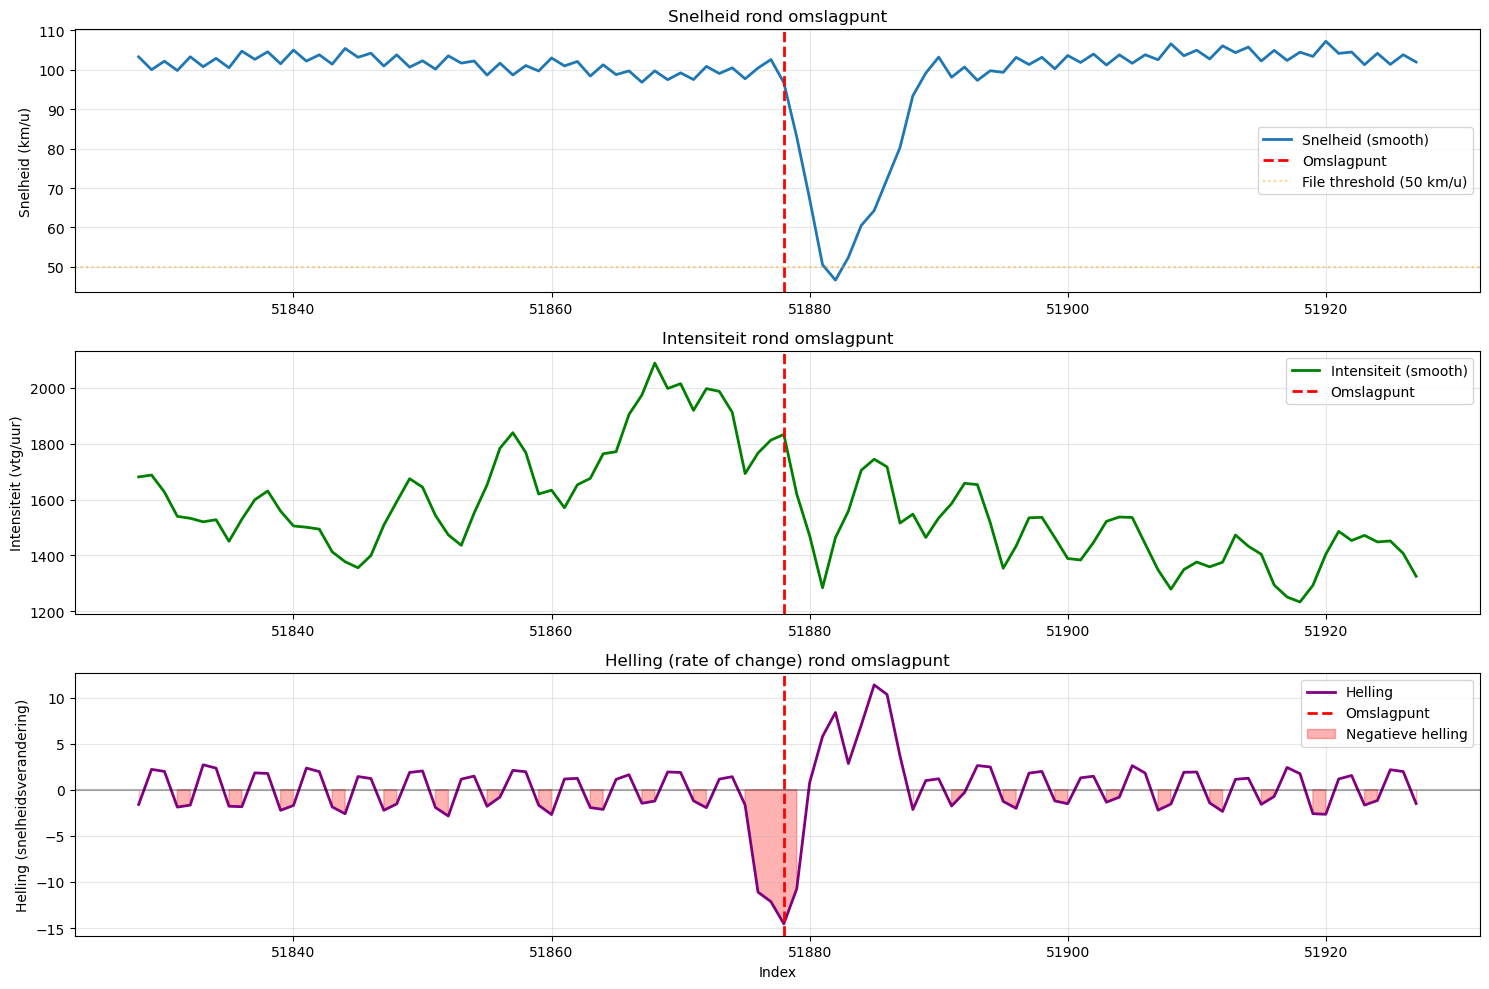

In [45]:
# Vind een omslagpunt
omslag_punt = df_clean[df_clean['file_omslag_flag'] == 1].iloc[10]
omslag_idx = omslag_punt.name

# Selecteer context rond het omslagpunt (50 voor, 50 na)
context_window = df_clean.iloc[max(0, omslag_idx-50):min(len(df_clean), omslag_idx+50)].copy()

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Plot 1: Snelheid (gebruik gesmoothte data)
axes[0].plot(context_window.index, context_window['gem_snelheid_smooth'], label='Snelheid (smooth)', linewidth=2)
axes[0].axvline(x=omslag_idx, color='red', linestyle='--', linewidth=2, label='Omslagpunt')
axes[0].axhline(y=50, color='orange', linestyle=':', alpha=0.5, label='File threshold (50 km/u)')
axes[0].set_ylabel('Snelheid (km/u)')
axes[0].set_title('Snelheid rond omslagpunt')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Intensiteit (gebruik gesmoothte data)
axes[1].plot(context_window.index, context_window['gem_intensiteit_smooth'], label='Intensiteit (smooth)', linewidth=2, color='green')
axes[1].axvline(x=omslag_idx, color='red', linestyle='--', linewidth=2, label='Omslagpunt')
axes[1].set_ylabel('Intensiteit (vtg/uur)')
axes[1].set_title('Intensiteit rond omslagpunt')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Helling
axes[2].plot(context_window.index, context_window['helling_per_punt'], label='Helling', linewidth=2, color='purple')
axes[2].axvline(x=omslag_idx, color='red', linestyle='--', linewidth=2, label='Omslagpunt')
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2].fill_between(context_window.index, 0, context_window['helling_per_punt'], 
                      where=(context_window['helling_per_punt'] < 0), alpha=0.3, color='red', label='Negatieve helling')
axes[2].set_ylabel('Helling (snelheidsverandering)')
axes[2].set_xlabel('Index')
axes[2].set_title('Helling (rate of change) rond omslagpunt')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Conclusie

We hebben succesvol een complete data preparatie pipeline doorlopen:

### Wat hebben we gedaan?

1. **Data Cleaning** (remove_missing, remove_negs, drop_low, drop_columns)
   - Verwijderd: technische storingen, ongeldige metingen, lage intensiteiten
   - Resultaat: Schone, betrouwbare meetdata

2. **Datetime Features** (datetime, time_to_int, dayofweek)
   - Toegevoegd: datum, tijd in seconden, dag van de week
   - Waarom: Tijdspatronen zijn cruciaal voor verkeersvoorspelling

3. **Data Smoothing** (smooth_data)
   - Methode: Savitzky-Golay filter
   - Waarom: Ruisonderdrukking terwijl trends behouden blijven

4. **Geo-verrijking** (merge_with_geo)
   - Toegevoegd: Wegtype, coördinaten uit NDW shapefiles
   - Resultaat: GeoDataFrame met ruimtelijke context

5. **File Detectie & Labeling** (add_helling_per_punt, detect_files, mark_omslagpunten)
   - Helling: Snelheidsverandering over 5-punt window
   - Files: Detectie op basis van 50 km/u threshold
   - Omslagpunten: Meest negatieve helling vóór file
   - Dit is de **target variabele** voor ML

6. **Sampling** (undersample)
   - Ratio: 3:1 (normaal : omslagpunt)
   - Waarom: Class imbalance oplossen zonder te veel data te verliezen
